In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
df = pd.read_csv('heart_disease_dataset.csv')

In [4]:
# print(df.shape)
# print(df.head())
# categorization of columns for reference
# BinaryColumns = ['Smoker', 'Diabetes', 'Hypertension', 'FamilyHistory', 
#                  'PreviousHeartAttack', 'StrokeHistory']
    
# ContinuousColumns = ['Age', 'Cholesterol', 'BloodPressure', 'HeartRate', 'BMI', 'PhysicalActivity', 'AlcoholConsumption',
#                      'StressLevel', 'Income', 'MaxHeartRate', 'ST_Depression', 'NumberOfMajorVessels']
    
# CategoricalColumns = ['Gender', 'Diet', 'Ethnicity', 'EducationLevel', 
#                       'Medication', 'ChestPainType', 'ECGResults', 'Slope', 
#                       'Thalassemia', 'Residence', 'EmploymentStatus', 
#                       'MaritalStatus', 'ExerciseInducedAngina']

BinaryColumns = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 
                'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
ContinuousColumns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
CategoricalColumns = ['Sex', 'AgeCategory', 'Race', 'GenHealth', 'Diabetic']




In [5]:
# extract features
# binary_features = df[['PreviousHeartAttack', 'Diabetes', 'Smoker']].values
# continuous_features = df[['Age', 'BloodPressure', 'Cholesterol', 'MaxHeartRate', 'BMI', 'NumberOfMajorVessels']].values
# categorical_features = df[['ChestPainType', 'ECGResults', 'ST_Depression']]

binary_features = df[BinaryColumns]
continuous_features = df[ContinuousColumns].values
categorical_features = df[CategoricalColumns]

# one-hot encode categorical features 
binary_features = pd.get_dummies(binary_features, drop_first=True).values
categorical_features = pd.get_dummies(categorical_features, drop_first=True).values

# normalize continuous features
# NOTE: THIS IS DATA LEAKAGE! the validation set is also getting scaled here, meaning the test data 
# is influences the scaling parameters, leading to overly optimistic performance metrics
# this should be done AFTER the split! keep now for testing 
scaler = StandardScaler()
binary_features = scaler.fit_transform(binary_features)
continuous_features = scaler.fit_transform(continuous_features)

# combine all features
X = np.concatenate([binary_features, continuous_features, categorical_features], axis=1)

In [6]:

# extract target
y = df['HeartDisease'].values
# convert 'heart attack' and 'not heart attack' to binary output
y = (y == 'Yes').astype(int)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32).view(-1, 1)

In [7]:
# note: after one hot encoding, each category from each categorical feature becomes its own feature
# therefore, for example, 9 chosen columns could actually mean 14 columns
# remember that when creating the first NN layer!
print(X.shape)

(319795, 37)


In [8]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(37, 128) # input layer. note: first input dim must match number of input features
        self.bn1 = nn.BatchNorm1d(128)      
        self.fc2 = nn.Linear(128, 64)         
        self.bn2 = nn.BatchNorm1d(64)       
        self.fc3 = nn.Linear(64, 16)          
        self.bn3 = nn.BatchNorm1d(16)         
        self.fc_out = nn.Linear(16, 1)       
        self.dropout1 = nn.Dropout(p=0.2)    
        self.dropout2 = nn.Dropout(p=0.1)     

        # Initialize weights
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc_out.weight, nonlinearity='relu')

    def forward(self, x):
        # first hidden layer
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        # second hidden layer
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        
        # third hidden layer
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        
        # output layer (no activation, since we're using BCEWithLogitsLoss)
        x = self.fc_out(x)
        return x

In [34]:
# hyper-parameters
learn_rate = 0.001
epochs = 800
batch_size = 128

In [35]:
# set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# instantiate the model, move it to GPU
model = NN().to(device)

# loss function 
criterion = nn.BCEWithLogitsLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = learn_rate)

# train loader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# move training and testing data to GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Using device: cuda


In [36]:
# training and validation
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


# batch training
# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()

# direct whole-set training
for epoch in range(epochs):
    # training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy on the entire training set
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train)
        train_predictions = (train_outputs > 0.5).float()
        train_correct = (train_predictions == y_train).float().sum()
        train_accuracy = train_correct / y_train.shape[0]

    # Store training metrics
    train_losses.append(loss.item())
    train_accuracies.append(train_accuracy.item())

    # Validation phase
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_predictions = (val_outputs > 0.5).float()
        val_correct = (val_predictions == y_test).float().sum()
        val_accuracy = val_correct / y_test.shape[0]

    # Store validation metrics
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # Print metrics every few epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy.item():.4f}, '
              f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy.item():.4f}')

Epoch [100/800], Training Loss: 0.4560, Training Accuracy: 0.9122, Validation Loss: 0.4469, Validation Accuracy: 0.9093
Epoch [200/800], Training Loss: 0.2962, Training Accuracy: 0.9166, Validation Loss: 0.2971, Validation Accuracy: 0.9123
Epoch [300/800], Training Loss: 0.2429, Training Accuracy: 0.9162, Validation Loss: 0.2487, Validation Accuracy: 0.9117
Epoch [400/800], Training Loss: 0.2297, Training Accuracy: 0.9160, Validation Loss: 0.2382, Validation Accuracy: 0.9114
Epoch [500/800], Training Loss: 0.2257, Training Accuracy: 0.9160, Validation Loss: 0.2358, Validation Accuracy: 0.9114
Epoch [600/800], Training Loss: 0.2237, Training Accuracy: 0.9159, Validation Loss: 0.2354, Validation Accuracy: 0.9112
Epoch [700/800], Training Loss: 0.2227, Training Accuracy: 0.9160, Validation Loss: 0.2352, Validation Accuracy: 0.9113
Epoch [800/800], Training Loss: 0.2218, Training Accuracy: 0.9159, Validation Loss: 0.2352, Validation Accuracy: 0.9112


Maximum Training Accuracy: 0.9167
Maximum Validation Accuracy: 0.9125


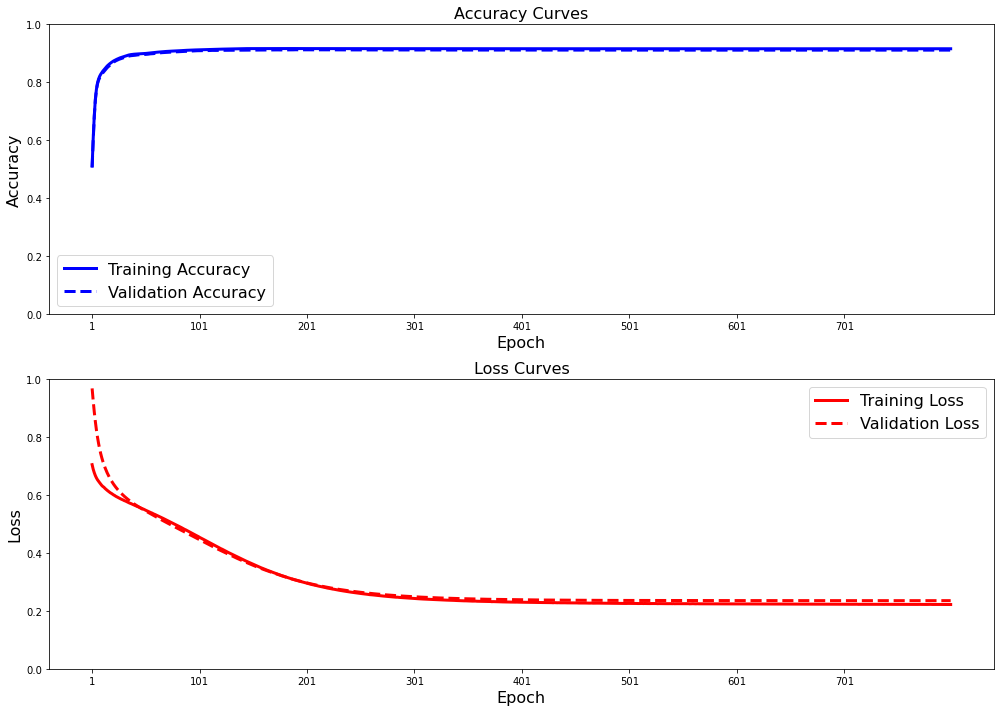

In [37]:
# max accuracies
print(f"Maximum Training Accuracy: {max(train_accuracies):.4f}")
print(f"Maximum Validation Accuracy: {max(val_accuracies):.4f}")

# accuracy curves
plt.figure(figsize=[14, 10])
plt.subplot(2, 1, 1) # note: divides output into 2 rows, 1 col, and this figure has position 1
plt.plot(train_accuracies, 'b', linewidth=3.0, label='Training Accuracy')
plt.plot(val_accuracies, 'b--', linewidth=3.0, label='Validation Accuracy')
plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0, 1)
plt.xticks(np.arange(0, epochs, 100), np.arange(1, epochs + 1, 100))
plt.title('Accuracy Curves', fontsize=16)

# loss curves
plt.subplot(2, 1, 2)
plt.plot(train_losses, 'r', linewidth=3.0, label='Training Loss')
plt.plot(val_losses, 'r--', linewidth=3.0, label='Validation Loss')
plt.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim(0, 1)
plt.xticks(np.arange(0, epochs, 100), np.arange(1, epochs + 1, 100))
plt.title('Loss Curves', fontsize=16)

plt.tight_layout()
plt.show()